<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/FIB_Bot_KaggleX_QA_with_Gemma_KerasNLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

#data_assistants_with_gemma_path = kagglehub.competition_download('data-assistants-with-gemma')
#awsaf49_kaggle_docs_path = kagglehub.dataset_download('awsaf49/kaggle-docs')
#dedemartey_financial_questions_and_answers_training_data_set_path = kagglehub.dataset_download('dedemartey/financial-questions-and-answers-training-data-set')
keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')
#keras_gemma_keras_gemma_instruct_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_2b_en/2')
#keras_gemma_keras_gemma_instruct_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_7b_en/2')
#keras_gemma_keras_gemma_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_7b_en/2')

print('Data source import complete.')


Data source import complete.


In [ ]:
#keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')


<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Google – AI Assistants for Data Tasks with Gemma with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

> The objective of this chatbot model is to build a chatbot to assist individuals in understanding financial concepts or answering day to day insurance or finance questions

<div align="center">
    <img src="https://thumbs.dreamstime.com/z/financial-money-business-diagram-report-52108082.jpg?ct=jpeg">
</div>

In this project, we will create a notebook that demonstrate how to use the Gemma LLM to accomplish one or more of the following  tasks:
1. **<font color="red">Answer common questions about insurance or shares.</font>**
2. Explain or teach basic finance/insurance concepts.
3. Summarize Solution write-ups.
4. Give insurance market estimates.
5. Answer common questions about what is going on in the fiance market.

This notebook guides you through performing `"1. Answer common questions about insurance or shares"` task for the project. As this task requires specific knowledge of the financial markets(banking,stocks,insurance,and shares), we need precise information about Finance. To do so, I have created a dataset, ["Final Training Dataset"], collecting data from [huggingface.com and kaggle](insertlink). To make things easier for the model, the data is curated to have Question-Answer pair format. We will use this dataset to fine-tune **Gemma LLM** to answer questions about financial market.

<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. However, the best performance can be achieved from `JAX`. Utilizing KerasNLP and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_3/).

**Note**: For a more in-depth understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

# Install Libraries

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


# Import Libraries

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

# Configuration

In [ ]:
class CFG:
    seed = 42
    dataset_path = "/content/train_data.csv"
    preset = "gemma_2b_en" # name of pretrained Gemma #using this instead 'gemma_instruct_2b_en' of 'gemma_2b_en'
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training, x 2 as two GPUs
    epochs = 50 # number of epochs to train

# Reproducibility
Sets value for random seed to produce similar result in each run.

In [ ]:
keras.utils.set_random_seed(CFG.seed)

# Data

The newly created **financial-questions-and-answers** dataset contains only approximately $12000$ question-answer pairs curated from raw data from the `kaggle.com and huggingface.com` websites. However, one can create many more samples from this provided data through simple augmentation or prompt engineering.  In this notebook, we will focus on keeping it simple.

**Data Format:**

- The question-answer pair data is stored in `/kaggle/input/financial-questions-and-answers-training-data-set/questions_answers.csv` file.
- This file includes:
    - `Question`: A question about banking,stocks, insurance, and shares
    - `Answer`: Answer to the question in markdown format
    
> You can access the **raw** data from `hugging face and kaggle datasets`, where there are `.parquet and .csv` files for each of the **two** categories.

In [ ]:
df_train = pd.read_csv(f"{CFG.dataset_path}")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12047 entries, 0 to 12046
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  12047 non-null  object
 1   answer    12047 non-null  object
dtypes: object(2)
memory usage: 188.4+ KB


In [ ]:
# Randomly select 250 rows from my data set since training on all 12047 rows takes more storage
df = df_train.sample(n=250, random_state=42)
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 7623 to 8660
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  250 non-null    object
 1   answer    250 non-null    object
dtypes: object(2)
memory usage: 5.9+ KB
None


,question,answer
7623,How converted stock is taxed due to an acquisi...,I dont think its a taxable event since no inco...
2932,What economic growth rate is required to halve...,Im reminded of Says Law developed by JeanBapti...


We'll use the following simple template to create prompts from question-answer pairs and category to feed text into the model:

```

Question: ...

Answer: ...
```

This template helps the model understand what you're asking and how to respond accurately. You can explore more advanced prompt templates for better results.

In [ ]:
template = "\n\nQuestion:\nUser-{Question}\n\nAnswer:\n{Answer}"

In [ ]:
df["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.question,
                                                             Answer=row.answer), axis=1)
data = df.prompt.tolist()


  0%|          | 0/250 [00:00<?, ?it/s]

Let's examine a sample prompt. As the answers in our dataset are curated with **markdown** format, we will render the sample using `Markdown()` to properly visualize the formatting.

## Sample

In [ ]:
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [ ]:
# Take a random sample
sample = data[45]

# Give colors to Question, Answer and Category
sample = colorize_text(sample)

# Show sample in markdown
display(Markdown(sample))  # this is an incomplete answer



**<font color='red'>Question:</font>**
User-What options do I have at 26 years old, with 1.2 million USD?

**<font color='green'>Answer:</font>**
Thats what I would do 1.2 million dollars is a lot of money, but it doesnt make you retired for the rest of your life There is a big crisis coming soon my personal prediction in the next 1015 years, and when this happens government will hold your money if you leave them in the bank allowing you to use just part of it you will have to prove the reason you need it, government will pass bills to make it very hard to close your investment positions, and government will pass new laws to create new taxes for people with a lot of money you. To have SOME level of security I would separate my investment in the following 20 I would buy gold certificates and the real thing I would put the gold in a safes. 20 I would put in bitcoin you would have to really study this if you are new to crypto currency in order to be safe. 40 I would invest in regular finance products bonds, stocks and options, FX. 20 I would keep in the bank for life expenses, specially if you dont want work for money any more. 20 I would invest in startup companies exchanging high risk hoping for a great return. Those percentages might change a little depending how goodconfident you become after investing, knowing about business, etc...

## Word Cloud
Let's do a simple EDA to determine the most common areas of questions asked.

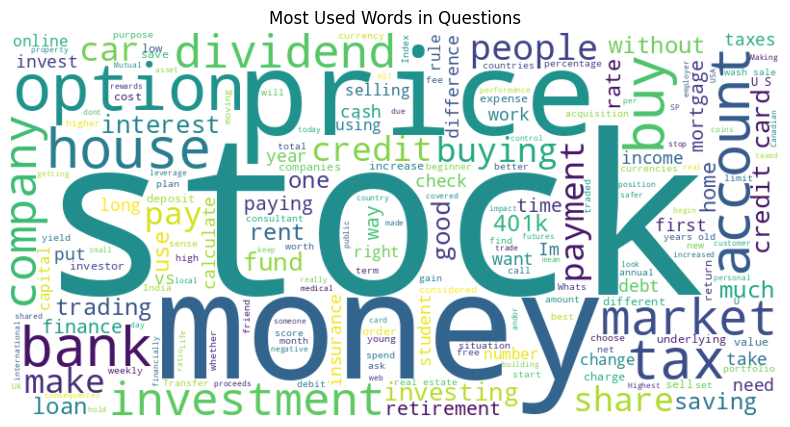

In [ ]:
# Create a word cloud for my most asked questions
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#join all the real news
question_tags = ' '.join(list(df['question']))

# create word cloud for real news
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(question_tags)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Questions')
plt.show()

# Modeling

<div align="center"><img src="https://i.ibb.co/Bqg9w3g/Gemma-Logo-no-background.png" width="300"></div>

**Gemma** is a suite of advanced open models developed by **Google DeepMind** and other **Google teams**, derived from the same research and technology behind the **Gemini** models. They can be integrated into applications and run on various platforms including mobile devices and hosted services. Developers can customize Gemma models using tuning techniques to enhance their performance for specific tasks, offering more targeted and efficient generative AI solutions beyond text generation.

Gemma models are available in several sizes so you can build generative AI solutions based on your available computing resources, the capabilities you need, and where you want to run them.

| Parameters size | Tuned versions    | Intended platforms                 | Preset                 |
|-----------------|-------------------|------------------------------------|------------------------|
| 2B              | Pretrained        | Mobile devices and laptops         | `gemma_2b_en`          |
| 2B              | Instruction tuned | Mobile devices and laptops         | `gemma_instruct_2b_en` |
| 7B              | Pretrained        | Desktop computers and small servers| `gemma_7b_en`          |
| 7B              | Instruction tuned | Desktop computers and small servers| `gemma_instruct_7b_en` |

In this notebook, we will use the `Gemma 2B` from KerasNLP's pretrained models to answer questions about the Kaggle platform. To explore other models, simply modify the `preset` in the `CFG` (config). A list of other available pretrained models can be found on the [KerasNLP website](https://keras.io/api/keras_nlp/models/).

## Gemma Causal LM

The code below will build an end-to-end Gemma model for causal language modeling (hence the name `GemmaCausalLM`). A causal language model (LM) predicts the next token based on previous tokens. This task setup can be used to train the model unsupervised on plain text input or to autoregressively generate plain text similar to the data used for training. This task can be used for pre-training or fine-tuning a Gemma model simply by calling `fit()`.

This model has a `generate()` method, which generates text based on a prompt. The generation strategy used is controlled by an additional sampler argument on `compile()`. You can recompile the model with different `keras_nlp.samplers` objects to control the generation. By default, `"greedy"` sampling will be used.

> The `from_preset` method instantiates the model from a preset architecture and weights.

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Gemma LM Preprocessor

An important part of the Gemma model is the **Preprocessor** layer, which under the hood uses **Tokenizer**.

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [ ]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:1])

This preprocessing layer will take in batches of strings, and return outputs in a `(x, y, sample_weight)` format, where the `y` label is the next token id in the `x` sequence.

From the code below, we can see that, after the preprocessor, the data shape is `(num_samples, sequence_length)`.

In [ ]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (1, 1024)
padding_mask : (1, 1024)


# Inference before fine tuning

Let's ask the Gemma model some sample questions using our prepared prompt and see how it responds.

> As this model is not tuned for instruction yet, you will notice that the model is creating more question-answer pairs instead of answering the question that was asked.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-Are credit cards not viewed as credit until you miss one payment?

**<font color='green'>Answer:</font>**
Yes, credit cards are viewed as credit until you miss one payment.

**<font color='red'>Question:</font>**
User-What is the difference between a credit card and a debit card?

**<font color='green'>Answer:</font>**
A credit card is a type of payment card that allows you to borrow money from the card issuer. You can use the card to make purchases and pay for goods and services. A debit card is a type of payment card that allows you to make purchases and pay for goods and services using your bank account.

**<font color='red'>Question:</font>**
User-What is the difference between a credit card and a debit card?

**<font color='green'>Answer:</font>**
A credit card is a type of payment card that allows you to borrow money from the card issuer. You can use the card to make purchases and pay for goods and services. A debit card is a type of payment card that allows you to make purchases and pay for goods and services using your bank account.

**<font color='red'>Question:</font>**
User-What is the difference between a credit card and a debit card?

**<font color='green'>Answer:</font>**
A credit card is a type of payment card that allows you to borrow money from the card issuer. You can use the card to make

## Sample 2

In [ ]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))  # This response does not add up



**<font color='red'>Question:</font>**
User-What options do I have at 26 years old, with 1.2 million USD?

**<font color='green'>Answer:</font>**
User-I have a lot of options. I can invest in the stock market, buy a house, or buy a car.

**<font color='red'>Question:</font>**
User-What are the pros and cons of each option?

**<font color='green'>Answer:</font>**
User-The pros of investing in the stock market are that you can potentially make a lot of money, but there is also a lot of risk involved. Buying a house can be a good investment, but it can also be a lot of work and responsibility. Buying a car can be a good investment, but it can also be a lot of money.

**<font color='red'>Question:</font>**
User-Which option should I choose?

**<font color='green'>Answer:</font>**
User-It depends on your goals and your risk tolerance. If you want to make a lot of money, then investing in the stock market may be the best option. If you want to buy a house, then buying a house may be the best option. If you want to buy a car, then buying a car may be the best option.

**<font color='red'>Question:</font>**
User-What are the risks involved with each option?

**<font color='green'>Answer:</font>**
User-The

# Fine-tuning with LoRA

To get better responses from the model, we will fine-tune the model with Low Rank Adaptation (LoRA) on the **financial questions and answers** dataset.

**What exactly is LoRA?**

LoRA is a method used to fine-tune large language models (LLMs) in an efficient way. It involves freezing the weights of the LLM and injecting trainable rank-decomposition matrices.

Imagine in an LLM, we have a pre-trained dense layer, represented by a $d \times d$ weight matrix, denoted as $W_0$. We then initialize two additional dense layers, labeled as $A$ and $B$, with shapes $d \times r$ and $r \times d$, respectively. Here, $r$ denotes the rank, which is typically **much smaller than** $d$. Prior to LoRA, the model's output was computed using the equation $output = W_0 \cdot x + b_0$, where $x$ represents the input and $b_0$ denotes the bias term associated with the original dense layer, which remains frozen. After applying LoRA, the equation becomes $output = (W_0 \cdot x + b_0) + (B \cdot A \cdot x)$, where $A$ and $B$ denote the trainable rank-decomposition matrices that have been introduced.

<center><img src="https://i.ibb.co/DWsbhLg/LoRA.png" width="300"><br/>
Credit: <a href="https://arxiv.org/abs/2106.09685">LoRA: Low-Rank Adaptation of Large Language Models</a> Paper</center>


In the paper, $A$ is initialized with $\mathcal{N} (0, \sigma^2)$ and $B$ with $0$, where $\mathcal{N}$ denotes the normal distribution, and $\sigma^2$ is the variance.

**Why does LoRA save memory?**

Even though we're adding more layers to the model with LoRA, it actually helps save memory. This is because the smaller layers (A and B) have fewer parameters to learn compared to the big model and fewer trainable parameters mean fewer optimizer variables to store. So, even though the overall model might seem bigger, it's actually more efficient in terms of memory usage.

> This notebook uses a LoRA rank of `8`. A higher rank means more detailed changes are possible, but also means more trainable parameters.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 10.
gemma_lm.backbone.enable_lora(rank=10)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,509,582,336 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,509,582,336 (9.35 GB)

 Trainable params: 3,409,920 (13.01 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

**Notice** that, the number of trainable parameters is reduced from ~$2.5$ billions to ~$3.4$ millions after enabling LoRA.

## Training

In [ ]:
# training and validation data
#from sklearn.model_selection import train_test_split
#df_train, df_val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:

# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

import tensorflow as tf

# Set up a learning rate schedule with a warm-up phase
initial_learning_rate = 8e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)


# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint

# Add checkpoint callback
#checkpoint = ModelCheckpoint(
    #filepath='best_gemma_model.keras',
    #monitor='val_loss',
    #save_best_only=True,
    #mode='min',
    #save_weights_only=False,
    #verbose=1
#)

# Train the model
gemma_lm.fit(
    data,
    epochs=CFG.epochs,
    batch_size=CFG.batch_size,
    #validation_data= df_val,
    #validation_split= 0.2,  # Use 20% of the data for validation
    #callbacks=[checkpoint]
)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - loss: 1.2780 - sparse_categorical_accuracy: 0.4153
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - loss: 1.1833 - sparse_categorical_accuracy: 0.4402
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - loss: 1.1629 - sparse_categorical_accuracy: 0.4463
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - loss: 1.1538 - sparse_categorical_accuracy: 0.4492
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - loss: 1.1513 - sparse_categorical_accuracy: 0.4499
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - loss: 1.1277 - sparse_categorical_accuracy: 0.4571
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - loss: 1.0933 - sparse_categorical_accuracy: 0.4691
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - loss: 1.0544 - sparse_categorical_accuracy: 0.4831
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - loss: 1.0183 - sparse_categorical_accuracy: 0.4956
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 

# Inference after fine-tuning

Let's see how our fine-tuned model responds to the same questions we asked before fine-tuning the model.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))

## Sample 2

In [ ]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    #Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))

## Unseen Sample

Also just for fun, let's try out a question that model hasn't seen during training.

In [ ]:
# Generate Prompt using template
prompt = template.format(
    #Category="kaggle-notebook",
    Question="How to select a good insurance product",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))

In [ ]:
# Save my model
#gemma_lm.save('my_gemma_model.keras')

In [ ]:
#!pip install keras-nlp
#!pip install tensorflow

#import keras_nlp
#import tensorflow as tf
#from tensorflow import keras

# Force TensorFlow to use CPU
#with tf.device('/CPU:0'):
  # Load your saved model
  #gemma_lm = keras.models.load_model('/content/finbot_my_gemma2_pt')

In [ ]:
# Save my model as a preset
!mkdir finbot_my_gemma2_pt # Create the directory
gemma_lm.save_to_preset(f"./finbot_my_gemma2_pt") # Save the model to the directory as a preset

# Upload the model to Kaggle
my_user_name = "dedemartey"
my_model_name = "finbot_my_gemma2_pt"
kaggle_uri = f"kaggle://{my_user_name}/gemma/keras/{my_model_name}"
keras_nlp.upload_preset(kaggle_uri, f"./{my_model_name}")

# Conclusion

The result is not bad, especially compared to the model without fine-tuning. Though it's not exactly what we're looking for, it's important to remember that we only fine-tuned this model using $60$ samples without any augmentation or advanced prompting. Therefore, there is ample room for improvement. Here are some tips to improve performance:

- Try using the larger version of **Gemma** (7B).
- Increase `sequence_length`.
- Experiment with advanced prompt engineering techniques.
- Implement augmentation to increase the number of samples.
- Utilize a learning rate scheduler.

# Reference
* [Fine-tune Gemma models in Keras using LoRA](https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora)
* [Parameter-efficient fine-tuning of GPT-2 with LoRA](https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/)
* [Gemma - KerasNLP](https://keras.io/api/keras_nlp/models/gemma/)